# HAT-P-11 CaII H & K equivalent widths

In [1]:
%matplotlib inline
from glob import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

from utils import EchelleSpectrum, continuum_normalize, plot_spectrum

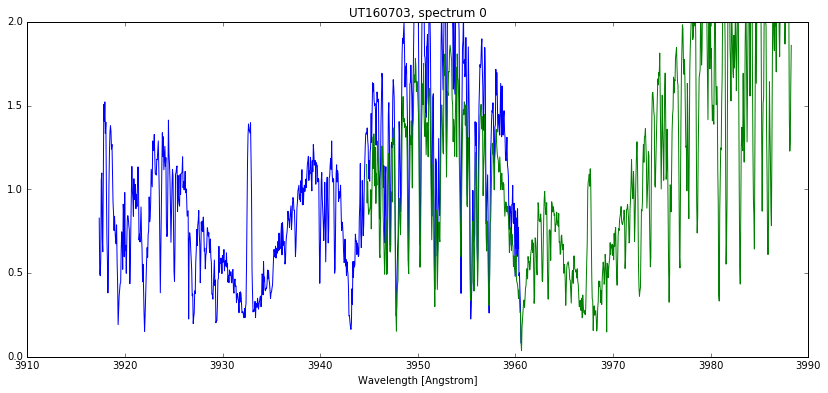

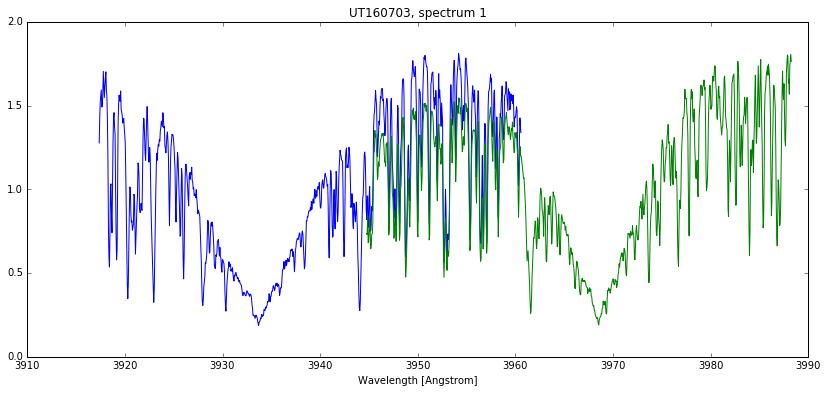

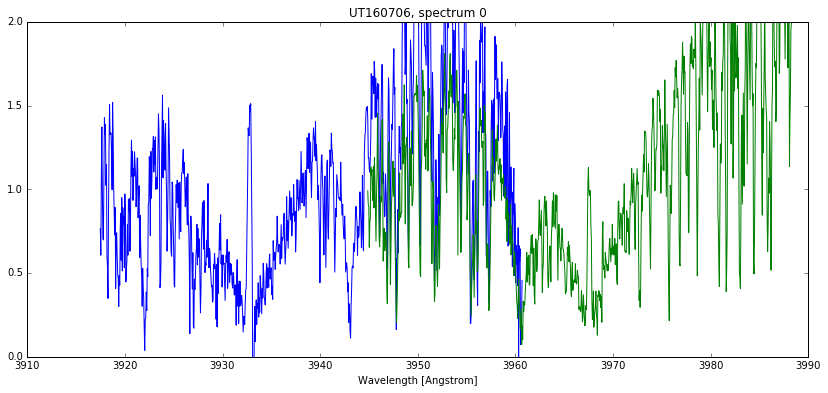

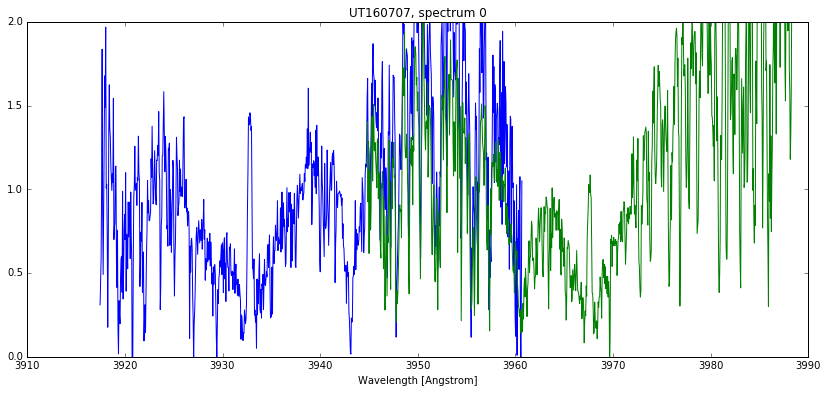

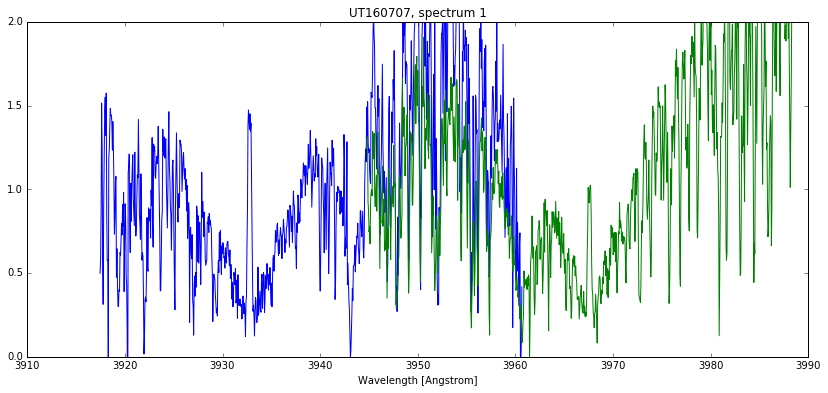

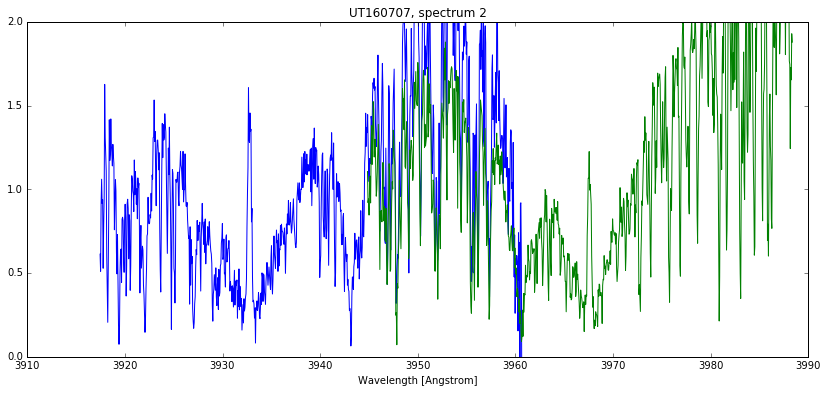

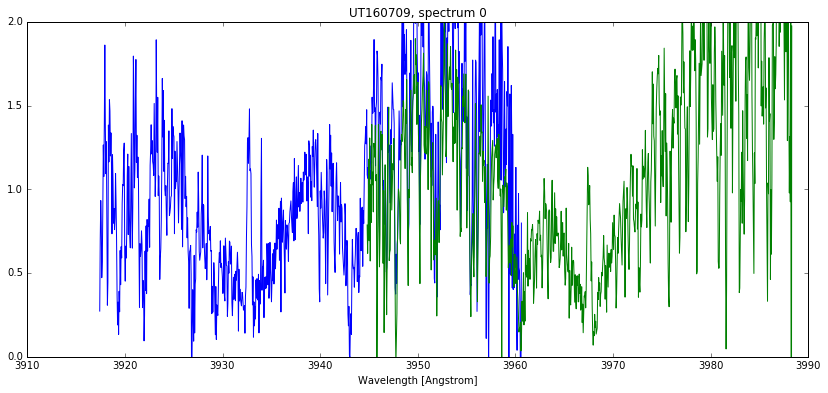

In [38]:
root_dir = '/media/PASSPORT/APO/Q3UW04/'
dates = ['UT160703', 'UT160706', 'UT160707', 'UT160709']
standard = 'BD28_4211'

all_normalized_spectra = []

date_index = 0
for date_index in range(len(dates)):
    data_dir = os.path.join(root_dir, dates[date_index])
    hat11_spectra_paths = glob(os.path.join(data_dir, 'HAT*.wfrmcpc.fits'))
    standard_spectra_paths = glob(os.path.join(data_dir, 
                                               "{0}*.wfrmcpc.fits".format(standard)))

    for spectrum_index in range(len(hat11_spectra_paths)):
        
        # Skip one bad observation:
        if not (spectrum_index == 3 and dates[date_index] == 'UT160707'):
            
            hat11_spectrum = EchelleSpectrum.from_fits(hat11_spectra_paths[spectrum_index])
            standard_spectrum = EchelleSpectrum.from_fits(standard_spectra_paths[0])

            normed_spectrum = continuum_normalize(hat11_spectrum, standard_spectrum, 
                                                  polynomial_order=8)
            all_normalized_spectra.append(normed_spectrum)
            
            plt.figure(figsize=(14, 6))
            plot_spectrum(normed_spectrum.get_order(90), margin=400)
            plot_spectrum(normed_spectrum.get_order(89), margin=400)
            plt.ylim([0, 2])
            plt.title('{0}, spectrum {1}'.format(dates[date_index], spectrum_index))
            plt.xlabel('Wavelength [Angstrom]')
            plt.show()

***

In [13]:

from astropy.modeling.models import Voigt1D, Lorentz1D
from astropy.modeling import fitting

#t_init = models.Trapezoid1D(amplitude=1., x_0=0., width=1., slope=0.5)
fit_model = fitting.SLSQPLSQFitter() # fitting.LevMarLSQFitter() # 
#t = fit_t(t_init, x, y)

approx_k = 3932.5 * u.Angstrom
approx_h = 3967.5 * u.Angstrom

def equivalent_width(normalized_spectrum, approx_wavelength, spectral_order, 
                     background_width=8*u.Angstrom, name=None, plot=False, 
                     use_right_wings=False):
    spectrum = normalized_spectrum.get_order(spectral_order)
    near_core = ((np.abs(spectrum.wavelength - approx_wavelength) < background_width))
    time = normalized_spectrum.header['DATE-OBS']
    
    if use_right_wings:
        near_core &= (spectrum.wavelength > approx_wavelength - 2*u.angstrom)
    
    wavelength = spectrum.wavelength[near_core]
    flux = spectrum.flux[near_core]
    
    # Normalize to the off-core flux:
    core_width = 1.5 * u.angstrom
    in_core = np.abs(wavelength - approx_wavelength) < core_width
    flux /= np.max(flux[~in_core])

    # Construct a model which has a Lorentzian component for absorption, 
    # a Voigt component for the emission
    init_params = (Lorentz1D(amplitude=-0.8, x_0=approx_wavelength.value, fwhm=7.5) + 
                   Voigt1D(x_0=approx_wavelength.value,
                           amplitude_L=1.0, fwhm_L=0.3, fwhm_G=0.2))
                
    composite_model = fit_model(init_params, wavelength.value, flux - 1,
                                maxiter=1000, acc=1e-8, disp=False)
    best_fit_model = composite_model(wavelength.value)
    
    # get just the best-fit Voigt profile, use it to measure the equivalent width:
    composite_model_params = {i: j for i, j in zip(composite_model.param_names, 
                                                   composite_model.parameters)}
    
    best_fit_core_model = Voigt1D(x_0=composite_model_params['x_0_1'],
                                  amplitude_L=composite_model_params['amplitude_L_1'],
                                  fwhm_L=composite_model_params['fwhm_L_1'], 
                                  fwhm_G=composite_model_params['fwhm_G_1'])
    
#     best_fit_wing_model = Lorentz1D(x_0=composite_model_params['x_0_0'],
#                                     amplitude=composite_model_params['amplitude_0'],
#                                     fwhm=composite_model_params['fwhm_0'])

    # Equivalent width is multiplied by -1 because wavelength array is in reverse order
    equiv_width_trapz = -1 * np.trapz(best_fit_core_model(wavelength.value),
                                      x = wavelength.value)

    if plot:
        fig, ax = plt.subplots(1)
        ax.plot(wavelength, flux)
        ax.plot(wavelength, best_fit_model + 1, 'r')
        ax.get_xaxis().get_major_formatter().set_useOffset(False)
        ax.set_title(name + " EW={0:.4f}".format(equiv_width_trapz))
#         fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#         ax[0].plot(wavelength, flux)
#         ax[0].plot(wavelength, best_fit_model + 1, 'r')
#         ax[0].get_xaxis().get_major_formatter().set_useOffset(False)
#         ax[0].set_title(name)
        
#         ax[1].plot(wavelength, flux - (best_fit_model + 1))
#         ax[1].get_xaxis().get_major_formatter().set_useOffset(False)
#         ax[1].set_title(name)
    return time, equiv_width_trapz


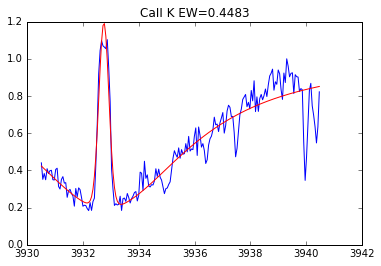

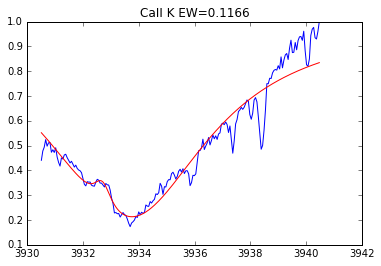

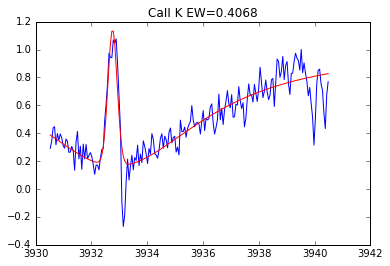

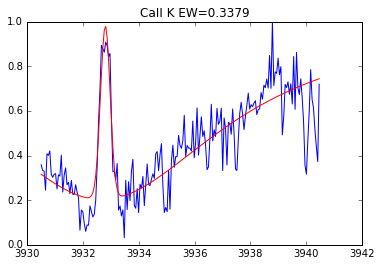

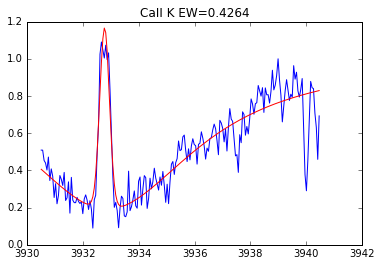

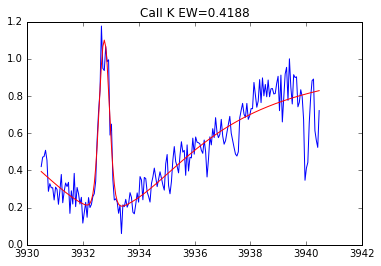

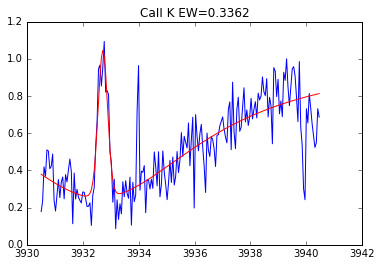

In [30]:
times_k = []
ew_k = []
for spectrum in all_normalized_spectra:
    time, ew = equivalent_width(spectrum, approx_k, 90, 
                                name='CaII K', plot=True, use_right_wings=True, 
                                background_width=8*u.Angstrom)
    ew_k.append(ew)
    times_k.append(time)
    plt.show()

****

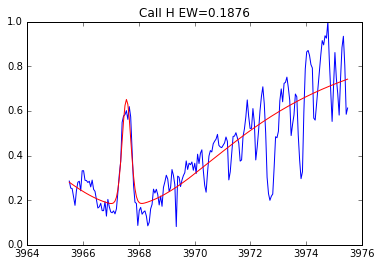

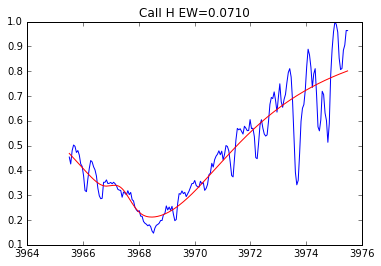

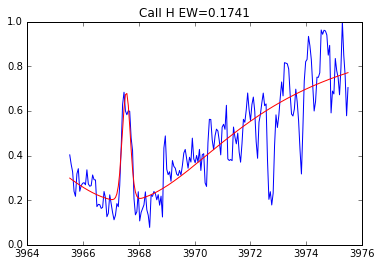

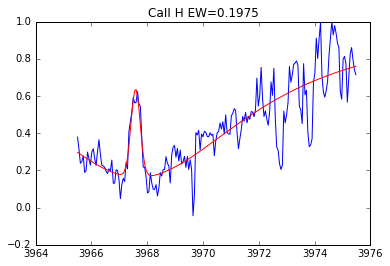

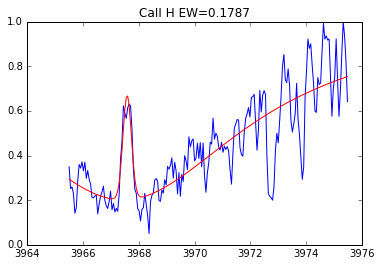

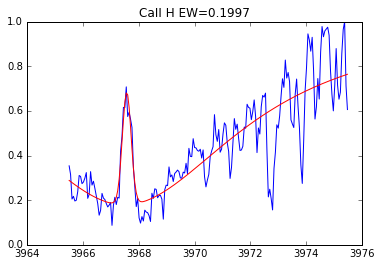

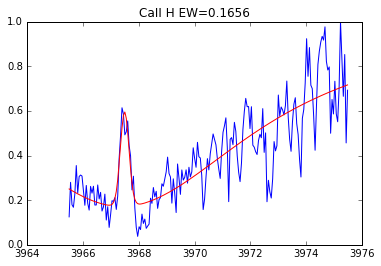

In [31]:
ew_h = []
times_h = []
for spectrum in all_normalized_spectra:
    times, ew = equivalent_width(spectrum, approx_h, 89, 
                                 name='CaII H', plot=True, use_right_wings=True, 
                                 background_width=8*u.Angstrom)
    ew_h.append(ew)
    times_h.append(times)
    plt.show()

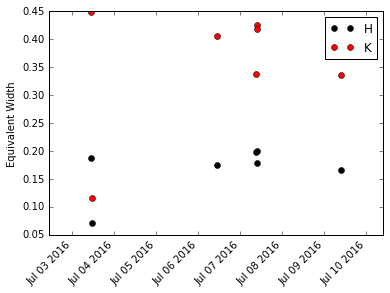

In [37]:
from astropy.time import Time
times_h_pd = Time(times_h, format='isot').plot_date
times_k_pd = Time(times_k, format='isot').plot_date
all_times = np.concatenate([times_h_pd, times_k_pd])

plt.plot_date(times_h_pd, ew_h, 'ko', label='H')
plt.plot_date(times_k_pd, ew_k, 'ro', label='K')
ax = plt.gca()

for l in ax.get_xticklabels():
    l.set_rotation(45)
    l.set_ha('right')

plt.xlim([all_times.min()-1, all_times.max()+1]) 
plt.ylabel('Equivalent Width')
plt.legend()
plt.show()